In [30]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from matplotlib.colors import from_levels_and_colors
from matplotlib.animation import FuncAnimation
from datetime import datetime, timedelta

from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)

In [7]:
fp = (r'/Users/alexyoung/Desktop/Cornell/Classes/Spring_2021/EAS_5555-Numerical_Climate_Modeling/'
      'WRF_Runs/DATA/March_28_Forecast/wrfout_d02_2021-03-28_00:00:00')
wrf_file = Dataset(fp)

# Get the Sea Level Pressure
slp = getvar(ncfile, "slp")

print(slp)

<xarray.DataArray 'slp' (south_north: 96, west_east: 111)>
array([[1038.8083 , 1038.8314 , 1038.8677 , ..., 1046.5074 , 1046.6542 ,
        1046.8174 ],
       [1038.6653 , 1038.7601 , 1038.779  , ..., 1046.0095 , 1046.1082 ,
        1046.219  ],
       [1038.7799 , 1038.7946 , 1038.673  , ..., 1045.4926 , 1045.5767 ,
        1045.6576 ],
       ...,
       [1023.6526 , 1023.9383 , 1024.2379 , ..., 1032.663  , 1032.5598 ,
        1032.4993 ],
       [1023.47736, 1023.6885 , 1023.925  , ..., 1032.6749 , 1032.5585 ,
        1032.4745 ],
       [1023.1521 , 1023.36945, 1023.629  , ..., 1032.6606 , 1032.5084 ,
        1032.4517 ]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -83.36844 -83.25354 ... -67.17096
    XLAT     (south_north, west_east) float32 37.840706 37.82387 ... 43.47127
    XTIME    float32 0.0
    Time     datetime64[ns] 2021-03-28
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY
    

<xarray.DataArray 'dbz' ()>
array(85995.53, dtype=float32)
Coordinates:
    XTIME    float32 600.0
    Time     datetime64[ns] 2021-03-28T10:00:00


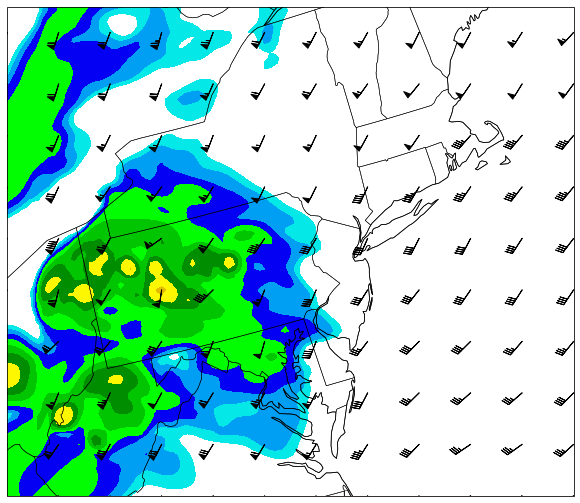

In [32]:
time_idx = 10

# Extract variables.
p = getvar(ncfile, "pressure", timeidx=time_idx)
z = getvar(ncfile, "z", units="dm", timeidx=time_idx)
dbz = getvar(wrf_file, "dbz", timeidx=time_idx)
ua = getvar(ncfile, "ua", units="kt", timeidx=time_idx)
va = getvar(ncfile, "va", units="kt", timeidx=time_idx)

# Compute the reflectivity. 
Z = 10**(dbz/10.) # Use linear Z for interpolation

# Interpolate geopotential height, u, and v winds to 500 hPa
ht_500 = interplevel(z, p, 500)
u_500 = interplevel(ua, p, 500)
v_500 = interplevel(va, p, 500)
Z_500 = interplevel(Z, p, 500)

# Convert back to dbz
dbz_500 = 10.0 * np.log10(Z_500)

# Get the lat/lon coordinates
lats, lons = latlon_coords(ht_500)

# Get the map projection information
cart_proj = get_cartopy(ht_500)

# Create the color table found on NWS pages.
dbz_levels = np.arange(5., 75, 5.)
print(np.max(Z[:]))
dbz_rgb = np.array([[4,233,231],
                    [1,159,244], [3,0,244],
                    [2,253,2], [1,197,1],
                    [0,142,0], [253,248,2],
                    [229,188,0], [253,149,0],
                    [253,0,0], [212,0,0],
                    [188,0,0],[248,0,253],
                    [152,84,198]], np.float32) / 255.0

dbz_map, dbz_norm = from_levels_and_colors(dbz_levels, dbz_rgb,
                                           extend="max")

# Create the figure
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=0.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# Add the reflectivity.
plt.contourf(to_np(lons), to_np(lats), to_np(dbz_500),
                            levels=dbz_levels,
                            cmap=dbz_map,
                            norm=dbz_norm,
                            transform=crs.PlateCarree())

# Add the 500 hPa wind barbs, only plotting every nth data point.
n_gap = 10
plt.barbs(to_np(lons[::n_gap,::n_gap]), to_np(lats[::n_gap,::n_gap]),
          to_np(u_500[::n_gap, ::n_gap]), to_np(v_500[::n_gap, ::n_gap]),
          transform=crs.PlateCarree(), length=6)

plt.show()

### Animate the precipitation.

MovieWriter Pillow unavailable; using Pillow instead.


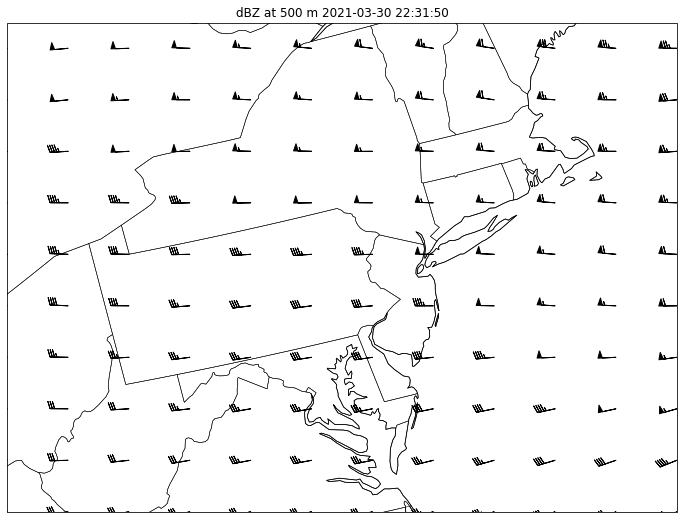

In [40]:
# Extract variables to initialize the figure.
p = getvar(ncfile, "pressure", timeidx=time_idx)
z = getvar(ncfile, "z", units="dm", timeidx=time_idx)

# Interpolate geopotential height, u, and v winds to 500 hPa
ht_500 = interplevel(z, p, 500)

# Get the lat/lon coordinates
lats, lons = latlon_coords(ht_500)

# Get the map projection information
cart_proj = get_cartopy(ht_500)

# Create the color table found on NWS pages.
dbz_levels = np.arange(5., 75, 5.)
dbz_rgb = np.array([[4,233,231],
                    [1,159,244], [3,0,244],
                    [2,253,2], [1,197,1],
                    [0,142,0], [253,248,2],
                    [229,188,0], [253,149,0],
                    [253,0,0], [212,0,0],
                    [188,0,0],[248,0,253],
                    [152,84,198]], np.float32) / 255.0

dbz_map, dbz_norm = from_levels_and_colors(dbz_levels, dbz_rgb,
                                           extend="max")

# Create the figure
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")

# Create a list of dates.
Nt = ncfile.dimensions['Time'].size
start_date = '2021-03-28 00:00:00'
dt = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
dt_str = datetime.strftime(dt, '%Y-%m-%d %H:%M:%S')
hour_dt = 72 / Nt
dates = []
for i in range(Nt):
    dates.append(dt_str)
    dt = dt + timedelta(hours=hour_dt)
    dt_str = datetime.strftime(dt, '%Y-%m-%d %H:%M:%S')

def animate(i):
    ax.clear()
    
    ax.add_feature(states, linewidth=0.5, edgecolor="black")
    ax.coastlines('50m', linewidth=0.8)
    
    # Extract variables.
    p = getvar(ncfile, "pressure", timeidx=i)
    z = getvar(ncfile, "z", units="dm", timeidx=i)
    dbz = getvar(wrf_file, "dbz", timeidx=i)
    ua = getvar(ncfile, "ua", units="kt", timeidx=i)
    va = getvar(ncfile, "va", units="kt", timeidx=i)

    # Compute the reflectivity. 
    Z = 10**(dbz/10.) # Use linear Z for interpolation

    # Interpolate geopotential height, u, and v winds to 500 hPa
    ht_500 = interplevel(z, p, 500)
    u_500 = interplevel(ua, p, 500)
    v_500 = interplevel(va, p, 500)
    Z_500 = interplevel(Z, p, 500)

    # Convert back to dbz
    dbz_500 = 10.0 * np.log10(Z_500)

    # Get the lat/lon coordinates
    lats, lons = latlon_coords(ht_500)
    
    # Add the reflectivity.
    dbz_contour = plt.contourf(to_np(lons), to_np(lats), to_np(dbz_500),
                            levels=dbz_levels,
                            cmap=dbz_map,
                            norm=dbz_norm,
                            transform=crs.PlateCarree())
    
    # Add the 500 hPa wind barbs, only plotting every nth data point.
    n_gap = 10
    barb_contour = plt.barbs(to_np(lons[::n_gap,::n_gap]), to_np(lats[::n_gap,::n_gap]),
          to_np(u_500[::n_gap, ::n_gap]), to_np(v_500[::n_gap, ::n_gap]),
          transform=crs.PlateCarree(), length=6)

    
    ax.set_title('dBZ at 500 m {}'.format(dates[i]))
    ax.set_aspect('auto')

anim = FuncAnimation(fig, animate, frames=49, interval=250)
anim.save('mar_28_dbz.gif', writer='Pillow')